In [1]:
import gensim
from gensim.models import Word2Vec
import numpy as np
from gensim.models.word2vec import Text8Corpus
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re


In [2]:
text8_path="text8"
analogy_file = "questions-words.txt"

In [3]:
           
def cosine_distance(v1, v2):
    return (1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

# Função para avaliar o modelo com dados de analogia
def evaluate_model(model, analogy_file):
    total_distance = 0
    count = 0
    
    with open(analogy_file, 'r') as f:
        for line in f:
            if line.startswith(':'):  # Ignorar categorias de analogia
                continue
            words = line.strip().split()
            if all(word in model.wv for word in words):
                # Operação de vetores
                result_vector = model.wv[words[1]] - model.wv[words[0]] + model.wv[words[2]]
                expected_vector = model.wv[words[3]]
                
                # Distância do cosseno
                distance = cosine_distance(expected_vector, result_vector)
                total_distance += distance
                count += 1
    return total_distance / count if count > 0 else float('inf')


In [4]:
def train_model(model_params: dict, corpus: list) -> Word2Vec.__class__:
    model = Word2Vec(
        sentences=corpus,
        vector_size=model_params['vector_size'],
        window=model_params['window'],
        sg=model_params['sg'],  # CBOW (0) ou Skip-gram (1)
        alpha=model_params['alpha'],  # Taxa de aprendizado inicial
        negative=model_params['negative'],
        min_count=5,
        workers=4,
    )
    
    return model

In [5]:
# Função principal
def train_and_evaluate(analogy_file, parameters):
    corpus = Text8Corpus(text8_path)
    results = []
    min_distance = float('inf')
    best_model = Word2Vec()
    best_params = {}

    for param in parameters:
        print(f"Treinando modelo com parâmetros: {param}")
        model = train_model(param, corpus)
        
        # Avaliação do modelo
        distance = evaluate_model(model, analogy_file)
        results.append((param, distance))

        if ( distance < min_distance ):
            min_distance = distance
            best_model = model
            best_params = param

        print(f"Distância média: {distance}")

    
    print("\nMelhor modelo:", best_params)
    print("Menor distância média:", min_distance)

    return best_model, best_params

In [6]:
# Parâmetros para experimentação
parameters = [
    #CBOW 
    {'vector_size': 10, 'window': 3, 'sg': 0, 'alpha': 0.001, 'negative': 5},
    {'vector_size': 10, 'window': 5, 'sg': 0, 'alpha': 0.001, 'negative': 5},  
    {'vector_size': 10, 'window': 10, 'sg': 0, 'alpha': 0.001, 'negative': 5}, 
    {'vector_size': 30, 'window': 3, 'sg': 0, 'alpha': 0.001, 'negative': 5},
    {'vector_size': 30, 'window': 5, 'sg': 0, 'alpha': 0.001, 'negative': 5},  
    {'vector_size': 30, 'window': 10, 'sg': 0, 'alpha': 0.001, 'negative': 5}, 

    # Skip-gram 
    {'vector_size': 10, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5},  
    {'vector_size': 10, 'window': 5, 'sg': 1, 'alpha': 0.001, 'negative': 5}, 
    {'vector_size': 10, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5},
    {'vector_size': 30, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5},  
    {'vector_size': 30, 'window': 5, 'sg': 1, 'alpha': 0.001, 'negative': 5}, 
    {'vector_size': 30, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5},

]

# Executar
best_model, best_params = train_and_evaluate(analogy_file, parameters)

Treinando modelo com parâmetros: {'vector_size': 10, 'window': 3, 'sg': 0, 'alpha': 0.001, 'negative': 5}
Distância média: 0.5816872982514105
Treinando modelo com parâmetros: {'vector_size': 10, 'window': 5, 'sg': 0, 'alpha': 0.001, 'negative': 5}
Distância média: 0.604495096009925
Treinando modelo com parâmetros: {'vector_size': 10, 'window': 10, 'sg': 0, 'alpha': 0.001, 'negative': 5}
Distância média: 0.6269396776206094
Treinando modelo com parâmetros: {'vector_size': 30, 'window': 3, 'sg': 0, 'alpha': 0.001, 'negative': 5}
Distância média: 0.5769650188182212
Treinando modelo com parâmetros: {'vector_size': 30, 'window': 5, 'sg': 0, 'alpha': 0.001, 'negative': 5}
Distância média: 0.6001829169416326
Treinando modelo com parâmetros: {'vector_size': 30, 'window': 10, 'sg': 0, 'alpha': 0.001, 'negative': 5}
Distância média: 0.6223691175489479
Treinando modelo com parâmetros: {'vector_size': 10, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Distância média: 0.25982607473835856
Trei

How many words were learnt?

In [7]:
len(best_model.wv.key_to_index) 

71290

In [8]:
def test_analogies(model, test_cases):
    print("\nTestando analogias experimentais:")
    for analogy in test_cases:
        word_a, word_b, word_c = analogy[:3]
        if all(word in model.wv for word in [word_a, word_b, word_c]):
            result_vector = model.wv[word_b] - model.wv[word_a] + model.wv[word_c]
            closest_word = model.wv.most_similar([result_vector], topn=1)[0][0]
            print(f"{word_a} -> {word_b}, {word_c} -> {closest_word}")
            print( model.wv.most_similar([result_vector], topn=5))

In [9]:
test_cases = [
    ['boy', 'brother', 'girl'],
    ["man", "king", "woman"],  
    ["paris", "france", "berlin"],     
    ["man", "actor", "woman"],
    ["man", "husband", "woman"],
    ["day", "sun", "night"]
]
test_analogies(best_model, test_cases)


Testando analogias experimentais:
boy -> brother, girl -> daughter
[('daughter', 0.9718688726425171), ('son', 0.96685791015625), ('wife', 0.9597024321556091), ('married', 0.9564929604530334), ('brother', 0.9535378813743591)]
man -> king, woman -> emperor
[('emperor', 0.985628604888916), ('pope', 0.9805377721786499), ('sons', 0.9789015650749207), ('king', 0.9757578372955322), ('prince', 0.9663566946983337)]
paris -> france, berlin -> germany
[('germany', 0.9890055060386658), ('russia', 0.9877108335494995), ('israeli', 0.9849409461021423), ('finland', 0.9816819429397583), ('united', 0.9810136556625366)]
man -> actor, woman -> actress
[('actress', 0.9863923788070679), ('actor', 0.9849656820297241), ('singer', 0.9818601608276367), ('musician', 0.9662694334983826), ('composer', 0.960141122341156)]
man -> husband, woman -> husband
[('husband', 0.9730583429336548), ('daughters', 0.9513264894485474), ('divorced', 0.9498974084854126), ('younger', 0.9463658928871155), ('married', 0.944023609161

In [10]:
print(cosine_distance(best_model.wv['man'], best_model.wv['woman'])) 

0.028678715229034424


In [11]:
print(best_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))

[('emperor', 0.9833436608314514), ('sons', 0.9798372387886047), ('pope', 0.9768761396408081), ('married', 0.9673745632171631), ('constantine', 0.963466227054596), ('lady', 0.9621750116348267), ('elizabeth', 0.9620877504348755), ('prince', 0.9618741869926453), ('murdered', 0.9613140225410461), ('julius', 0.9610971808433533)]


Which are the most feminine words?

In [12]:
print(best_model.wv.most_similar(positive=['woman'], negative=['man'], topn=10))


[('narendra', 0.6768335700035095), ('climacus', 0.637901782989502), ('nadesico', 0.6211317181587219), ('dogpatch', 0.6187779307365417), ('dimanche', 0.6104142069816589), ('anzio', 0.6088247299194336), ('cheong', 0.6064728498458862), ('matique', 0.6064265370368958), ('coiner', 0.6040307879447937), ('kentauros', 0.5991018414497375)]


And the most masculine?

In [13]:
print(best_model.wv.most_similar(positive=['man'], negative=['woman'], topn=10))


[('perdiccas', 0.41870424151420593), ('intelligence', 0.410832017660141), ('law', 0.3990551233291626), ('right', 0.3955104351043701), ('magnes', 0.39320337772369385), ('lynchburg', 0.3896403908729553), ('berichte', 0.3835461735725403), ('branch', 0.3821200728416443), ('clamped', 0.3793090581893921), ('belton', 0.37457525730133057)]


## Visualizing in a 2D space

In [14]:
def tsne_plot(words, vectors, iterations=1000, seed=42, title="t-SNE Word Embeddings"):
    """
    Creates a t-SNE plot of word embeddings.
    
    Parameters:
    - words: List of words to plot.
    - vectors: Corresponding vectors for the words.
    - iterations: Number of t-SNE iterations.
    - seed: Random seed for reproducibility.
    - title: Title for the plot.
    """
    # Create t-SNE model and fit-transform the vectors
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', 
                       max_iter=iterations, random_state=seed)
    new_values = tsne_model.fit_transform(vectors)

    # Extract x and y coordinates
    x, y = new_values[:, 0], new_values[:, 1]

    # Plot the results
    plt.figure(figsize=(10, 10))
    
    # Annotate points with words
    for i in range(len(words)):
        
        plt.scatter(x[i], y[i])
        plt.annotate(words[i], xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title(title)
    plt.grid(True)
    plt.show()


In [15]:
# Initialize lists for words and their corresponding vectors
my_word_list = []
my_word_vectors = []

# List of words to explore
words_to_explore = [
    'woman', 'man', 'queen', 'king', 'human', 'person', 'girl', 'child', 'boy',
    'salad', 'lettuce', 'tomato', 'soup', 'turnip', 'arugula', 'pepper', 
    'greens', 'barley', 'bean', 'stew', 'carrot'
]

for word in words_to_explore:
    try:
        if word not in my_word_list:
            my_word_vectors.append(best_model.wv[word])
            my_word_list.append(word)
    except KeyError:  # Ignore words not in the vocabulary
        continue


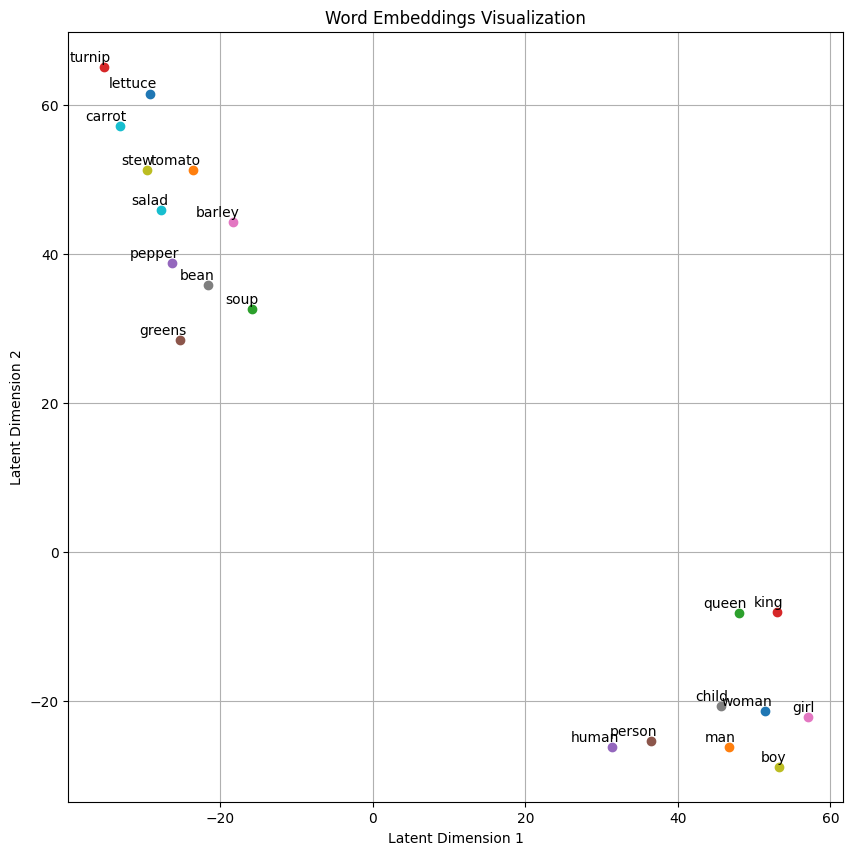

In [16]:
# Generate the t-SNE plot
tsne_plot(my_word_list, np.array(my_word_vectors), iterations=1000, seed=42, title="Word Embeddings Visualization")
